- Nombre: Marcus Alexander Mayorga Martínez
- Fecha: 25 de mayo del 2025
- Repositorio: https://github.com/GamersEC/autonomo-3-programacion

### Importaciones

In [135]:
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
from collections import Counter
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

### Clase Exemplar

In [136]:
class Exemplar:
    def __init__(self, features, label=None):
        self.features = np.asarray(features)
        self.label = label

    def __eq__(self, other):
        if not isinstance(other, Exemplar):
            return NotImplemented
        return np.array_equal(self.features, other.features)

    def __repr__(self):
        return f"Exemplar(features={self.features.tolist()}, label='{self.label}')"

### Clase KNNBase

In [137]:
class KNNBase(ABC):
    @staticmethod
    def euclidean_distance(p1, p2):
        #Calculamos la distancia euclidiana entre dos puntos p1 y p2
        return np.sqrt(np.sum((np.asarray(p1) - np.asarray(p2)) ** 2))

    @abstractmethod
    def fit(self, X_train, y_train):
        #Metodo abstracto para entrenar el modelo con los datos
        pass

    @abstractmethod
    def predict(self, X_new, k=3):
        #Metodo abstracto para predecir etiquetas para nuevos datos usando k vecinos
        pass


### Clase KNNClassifier

In [138]:
class KNNClassifier(KNNBase):
    def __init__(self):
        #Lista de objetos Exemplar
        self._exemplars = []
        #Caracteristicas originales del conjunto de entrenamiento
        self._X_train_features = None
        #Etiquetas originales del conjunto de entrenamiento
        self._y_train_labels = None

    def fit(self, X_train, y_train):
        #Reiniciamos la lista de ejemplares
        self._exemplars = []
        X_train_np = np.asarray(X_train)
        y_train_np = np.asarray(y_train)

        #Verificacion que el numero de muestras coincida
        if X_train_np.shape[0] != y_train_np.shape[0]:
            raise ValueError("X_train e y_train deben tener el mismo número de muestras.")

        #Creamos objetos Exemplar para cada muestra y su etiqueta
        for i in range(X_train_np.shape[0]):
            self._exemplars.append(Exemplar(X_train_np[i], y_train_np[i]))

        #Guarda los datos para uso futuro
        self._X_train_features = X_train_np
        self._y_train_labels = y_train_np

    def _predict_single(self, x_new_features, k):
        #Verificamos que el modelo haya sido entrenado
        if not self._exemplars:
            raise ValueError("El clasificador aún no ha sido entrenado (no se ha llamado a fit).")

        #Ajusta k si es inválido
        if k > len(self._exemplars):
            k = len(self._exemplars)
        if k <= 0:
            raise ValueError("k debe ser un entero positivo.")

        #Calcula la distancia a todos los ejemplares
        distances = []
        for exemplar in self._exemplars:
            dist = self.euclidean_distance(x_new_features, exemplar.features)
            distances.append((dist, exemplar.label))

        #Ordenar por distancia y obtiene las etiquetas de los k vecinos mas cercanos
        distances.sort(key=lambda item: item[0])
        neighbor_labels = [item[1] for item in distances[:k]]

        #Devuelve la etiqueta más comun
        most_common = Counter(neighbor_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X_new, k=3):
        #Convierte la entrada a array de NumPy para asegurar la compatibilidad
        X_new_np = np.asarray(X_new)
        if X_new_np.ndim == 1:
            X_new_np = X_new_np.reshape(1, -1)

        #Predice para cada muestra en X_new
        predictions = [self._predict_single(x_new_features, k) for x_new_features in X_new_np]
        return np.array(predictions)

    def __repr__(self):
        #Representacion legible del objeto
        return f"KNNClassifier(muestras_entrenamiento={len(self._exemplars)})"

    def __add__(self, other):
        #Permite combinar dos clasificadores KNN
        if not isinstance(other, KNNClassifier):
            return NotImplemented

        new_classifier = KNNClassifier()
        new_classifier._exemplars = self._exemplars + other._exemplars

        #Combina las caracteristicas y etiquetas de entrenamiento si estan disponibles
        current_X = self._X_train_features if self._X_train_features is not None else np.array([])
        current_y = self._y_train_labels if self._y_train_labels is not None else np.array([])
        other_X = other._X_train_features if hasattr(other, '_X_train_features') and other._X_train_features is not None else np.array([])
        other_y = other._y_train_labels if hasattr(other, '_y_train_labels') and other._y_train_labels is not None else np.array([])

        if current_X.size > 0 and other_X.size > 0:
            #Verificar la compatibilidad dimensional antes de combinar
            if current_X.ndim > 1 and other_X.ndim > 1 and current_X.shape[1] != other_X.shape[1]:
                raise ValueError("No se pueden combinar clasificadores con diferente número de características en _X_train_features.")
            if current_X.ndim > 1 or other_X.ndim > 1:
                combined_X = []
                if current_X.size > 0: combined_X.append(current_X.reshape(-1, current_X.shape[-1]) if current_X.ndim == 1 else current_X)
                if other_X.size > 0: combined_X.append(other_X.reshape(-1, other_X.shape[-1]) if other_X.ndim == 1 else other_X)
                if combined_X: new_classifier._X_train_features = np.vstack(combined_X)
                else: new_classifier._X_train_features = np.array([])
            else:
                new_classifier._X_train_features = np.concatenate((current_X, other_X))

            new_classifier._y_train_labels = np.concatenate((current_y, other_y))
        elif current_X.size > 0:
            new_classifier._X_train_features = current_X
            new_classifier._y_train_labels = current_y
        elif other_X.size > 0:
            new_classifier._X_train_features = other_X
            new_classifier._y_train_labels = other_y
        else:
            #Si no hay datos previos, se reconstruye a partir de los ejemplares
            if new_classifier._exemplars:
                new_classifier._X_train_features = np.array([ex.features for ex in new_classifier._exemplars])
                new_classifier._y_train_labels = np.array([ex.label for ex in new_classifier._exemplars])
            else:
                new_classifier._X_train_features = np.array([])
                new_classifier._y_train_labels = np.array([])

        return new_classifier



    ###Reto Extra: Metodo plot_neighbors
    def plot_neighbors(self, x_new_features, k, X_all_features_for_pca=None, y_all_labels_for_pca=None):
        #Verificar si el clasificador fue entrenado
        if not self._exemplars:
            raise ValueError("El clasificador aún no ha sido entrenado.")

        x_new_features_np = np.asarray(x_new_features)

        #Calcular distancias al nuevo punto
        distances = []
        for exemplar in self._exemplars:
            dist = self.euclidean_distance(x_new_features_np, exemplar.features)
            distances.append({'distance': dist, 'label': exemplar.label, 'features': exemplar.features})

        #Seleccionar los k vecinos mas cercanos
        distances.sort(key=lambda item: item['distance'])
        neighbors = distances[:k]
        neighbor_features = np.array([n['features'] for n in neighbors])
        neighbor_labels = np.array([n['label'] for n in neighbors])

        #Datos para ajustar PCA
        pca_fit_data_features = X_all_features_for_pca if X_all_features_for_pca is not None else self._X_train_features
        pca_fit_data_labels = y_all_labels_for_pca if y_all_labels_for_pca is not None else self._y_train_labels

        #Verificar si hay suficientes datos para aplicar PCA
        if pca_fit_data_features is None or pca_fit_data_features.shape[0] < 2 or pca_fit_data_features.shape[1] < 2:
            print("No hay suficientes datos o características para realizar PCA y graficar. Omitiendo plot_neighbors.")
            return

        #PCA personalizado
        def custom_pca(X, n_components=2):
            X_mean = np.mean(X, axis=0)
            X_meaned = X - X_mean
            cov_matrix = np.cov(X_meaned, rowvar=False)
            eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
            sorted_index = np.argsort(eigen_values)[::-1]
            sorted_eigenvectors = eigen_vectors[:, sorted_index]
            eigenvector_subset = sorted_eigenvectors[:, 0:n_components]
            X_reduced = np.dot(X_meaned, eigenvector_subset)
            return X_reduced, eigenvector_subset, X_mean

        #Aplicar PCA a los datos de fondo
        try:
            data_2d_background, pca_eigenvectors, pca_mean_used_for_fit = custom_pca(pca_fit_data_features, n_components=2)
        except np.linalg.LinAlgError:
            print("PCA falló. Omitiendo gráfico.")
            if pca_fit_data_features.shape[1] >= 2:
                print("Recurriendo a graficar las dos primeras características originales.")
                data_2d_background = pca_fit_data_features[:, :2]
                pca_eigenvectors = np.eye(pca_fit_data_features.shape[1])[:,:2]
                pca_mean_used_for_fit = np.zeros(pca_fit_data_features.shape[1])
            else:
                print("No se puede graficar: no hay suficientes características para una representación 2D.")
                return

        #Transformar los vecinos y el nuevo punto al espacio PCA 2D
        points_to_transform = np.vstack([neighbor_features, x_new_features_np])
        points_to_transform_meaned = points_to_transform - pca_mean_used_for_fit
        highlight_2d = np.dot(points_to_transform_meaned, pca_eigenvectors)

        neighbors_2d = highlight_2d[:-1, :]
        new_point_2d = highlight_2d[-1, :]

        plt.figure(figsize=(12, 8))

        #Colores para etiquetas
        unique_labels_background = np.unique(pca_fit_data_labels)

        colors_map = None
        if len(unique_labels_background) > 0:
            try:
                base_cmap = plt.colormaps.get_cmap('viridis')
                colors_map = base_cmap.resampled(len(unique_labels_background))
            except AttributeError:
                colors_map = plt.cm.get_cmap('viridis', len(unique_labels_background))

        #Graficar puntos del dataset
        if colors_map:
            for i, label in enumerate(unique_labels_background):
                indices = pca_fit_data_labels == label
                plt.scatter(data_2d_background[indices, 0], data_2d_background[indices, 1],
                            color=colors_map(i), label=f"Dataset: {label}", alpha=0.3, s=30)

            #Graficar vecinos cercanos
            unique_neighbor_labels = np.unique(neighbor_labels)
            for i, label in enumerate(unique_neighbor_labels):
                label_idx_in_all_unique = np.where(unique_labels_background == label)[0]
                color_for_label = colors_map(label_idx_in_all_unique[0]) if len(label_idx_in_all_unique) > 0 else 'gray'
                indices = neighbor_labels == label
                plt.scatter(neighbors_2d[indices, 0], neighbors_2d[indices, 1],
                            color=color_for_label, label=f"Vecino: {label}", marker='o', s=150, edgecolor='black', alpha=0.8)
        else:
            print("Advertencia: No se pudieron generar colores para el gráfico de fondo debido a la falta de etiquetas únicas.")

        #Graficar el nuevo punto
        plt.scatter(new_point_2d[0], new_point_2d[1],
                    color='red', label=f'Punto Nuevo (k={k})', marker='X', s=250, edgecolor='black', zorder=5)

        plt.title(f'Vecinos KNN (k={k}) en Espacio PCA 2D')
        plt.xlabel('Primer Componente Principal')
        plt.ylabel('Segundo Componente Principal')
        plt.legend()
        plt.grid(True)
        plt.show()

### Prueba de codigo

In [139]:
try:
    penguins_df = pd.read_csv('penguins.csv')
except FileNotFoundError:
    print("Error: 'penguins.csv' no encontrado.")
    penguins_df = pd.DataFrame({
        'species': ['Adelie', 'Adelie', 'Gentoo', 'Gentoo', 'Chinstrap', 'Chinstrap', 'Adelie', 'Gentoo'],
        'bill_length_mm': [39.1, 39.5, 46.1, 50.0, 48.0, 50.5, 35.0, 49.0],
        'bill_depth_mm': [18.7, 17.4, 13.2, 16.3, 15.0, 19.0, 17.0, 15.0],
        'flipper_length_mm': [181.0, 186.0, 211.0, 220.0, 215.0, 210.0, 190.0, 221.0],
        'body_mass_g': [3750.0, 3800.0, 4500.0, 5700.0, 5000.0, 4800.0, 3500.0, 5500.0],
        'sex': ['Male', 'Female', 'Female', 'Male', 'Male', 'Female', 'Female', 'Male']
    })
    print("\nUsando un dataset de prueba ya que 'penguins.csv' no fue encontrado.")

#Preprocesamiento Básico de Datos
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
target_column = 'species'

#Eliminar filas que tengan valores faltantes (NaN) en las columnas de características o en la columna objetivo
penguins_df_clean = penguins_df.dropna(subset=feature_columns + [target_column])

#Separar las características (X) y la variable objetivo (y)
X = penguins_df_clean[feature_columns].values
y = penguins_df_clean[target_column].values

print(f"\nForma del dataset después de la limpieza: X={X.shape}, y={y.shape}")
if X.shape[0] == 0:
    raise SystemExit("No quedan datos después de la limpieza. Por favor, revisa tu dataset.")


Forma del dataset después de la limpieza: X=(342, 4), y=(342,)


Instanciar el clasificador KNN

In [140]:
#Creamos una instancia del clasificador KNN
knn_classifier = KNNClassifier()

#Entrenamos el clasificador con las caracteristicas X y etiquetas y
knn_classifier.fit(X, y)

#Muestra una representación del clasificador, incluyendo el numero de muestras entrenadas
print(f"\nDetalles del clasificador: {knn_classifier}")



Detalles del clasificador: KNNClassifier(muestras_entrenamiento=342)


Demostración de __eq__ para Exemplars

In [141]:
print("\nDemostrando Exemplar __eq__ (igualdad entre ejemplares)")

#Verificae que haya al menos dos ejemplares entrenados para la comparacion
if len(knn_classifier._exemplars) >= 2:
    e1 = knn_classifier._exemplars[0]  #Primer ejemplar
    e2 = knn_classifier._exemplars[1]  #Segundo ejemplar

    #Tercer ejemplar con las mismas caracteristicas que e1 pero etiqueta diferente
    e3 = Exemplar(knn_classifier._exemplars[0].features, "AlgunaOtraEspecie")

    print(f"Ejemplar 1: {e1}")
    print(f"Ejemplar 2: {e2}")
    print(f"Ejemplar 3 (mismas características que E1): {e3}")
    print(f"e1 == e2: {e1 == e2}")  # Comparar caracteristicas de e1 y e2
    print(f"e1 == e3: {e1 == e3}")  # Comparar caracteristicas de e1 y e3

    print(f"e1 == 'texto': {e1 == 'texto'}")  # Compara un ejemplar con un tipo no compatible
else:
    print("No hay suficientes ejemplares en el clasificador entrenado para demostrar __eq__ entre dos ejemplares distintos.")

    #Si hay solo un ejemplar, se compara con una copia del mismo
    if len(knn_classifier._exemplars) == 1:
        e1 = knn_classifier._exemplars[0]
        e1_copy = Exemplar(e1.features, e1.label)
        print(f"Ejemplar 1: {e1}")
        print(f"Ejemplar 1 (copia): {e1_copy}")
        print(f"e1 == e1_copy: {e1 == e1_copy}")


Demostrando Exemplar __eq__ (igualdad entre ejemplares)
Ejemplar 1: Exemplar(features=[39.1, 18.7, 181.0, 3750.0], label='Adelie')
Ejemplar 2: Exemplar(features=[39.5, 17.4, 186.0, 3800.0], label='Adelie')
Ejemplar 3 (mismas características que E1): Exemplar(features=[39.1, 18.7, 181.0, 3750.0], label='AlgunaOtraEspecie')
e1 == e2: False
e1 == e3: True
e1 == 'texto': False


Demostración de __add__ para KNNClassifiers

In [142]:
print("\nDemostrando KNNClassifier __add__ (suma de clasificadores)")

#Verificar si hay suficientes datos para dividir el dataset
if X.shape[0] >= 4:

    #Divide los datos en dos mitades
    X1, y1 = X[:len(X) // 2], y[:len(y) // 2]
    X2, y2 = X[len(X) // 2:], y[len(y) // 2:]

    #Entrenar el primer clasificador con la primera mitad
    knn1 = KNNClassifier()
    knn1.fit(X1, y1)
    print(f"knn1: {knn1}")

    #Entrenar el segundo clasificador con la segunda mitad
    knn2 = KNNClassifier()
    knn2.fit(X2, y2)
    print(f"knn2: {knn2}")

    #Sumar ambos clasificadores
    knn_combined = knn1 + knn2
    print(f"knn_combinado (knn1 + knn2): {knn_combined}")

    #Verificar que el numero de ejemplares combinados sea correcto
    if len(knn_combined._exemplars) == len(knn1._exemplars) + len(knn2._exemplars):
        print("El clasificador combinado tiene el número correcto de ejemplares.")
    else:
        print("Error al combinar ejemplares para __add__.")
else:
    #Si hay pocos datos, se duplica el clasificador original como demostracion
    print("No hay suficientes datos para dividir y demostrar la suma de clasificadores adecuadamente.")
    knn_doubled = knn_classifier + knn_classifier
    print(f"knn_duplicado (original + original): {knn_doubled}")


Demostrando KNNClassifier __add__ (suma de clasificadores)
knn1: KNNClassifier(muestras_entrenamiento=171)
knn2: KNNClassifier(muestras_entrenamiento=171)
knn_combinado (knn1 + knn2): KNNClassifier(muestras_entrenamiento=342)
El clasificador combinado tiene el número correcto de ejemplares.


Realizar Predicciones para diferentes valores de k

In [143]:
print("\nPredicciones para diferentes valores de k")

#Seleccionar las primeras 5 muestras para predecir y sus etiquetas reales
X_to_predict = X[:5]
y_actual = y[:5]

#Lista para almacenar los resultados
results = []

#Diferentes valores de k a evaluar
k_values = [1, 3, 5]

#Mostrar informacion basica sobre las muestras a predecir
print(f"Prediciendo para {X_to_predict.shape[0]} muestras.")
print(f"Especies reales: {y_actual.tolist()}")

#Realizar predicciones para cada valor de k
for k_val in k_values:

    #Predecir usando el clasificador entrenado
    predictions = knn_classifier.predict(X_to_predict, k=k_val)

    #Guardar los resultados en una lista de diccionarios
    results.append({
        'k': k_val,
        'predicciones': predictions.tolist()
    })

    #Mostrar las predicciones para el valor actual de k
    print(f"k = {k_val}, Predicciones: {predictions.tolist()}")

#Crear un DataFrame para mostrar las predicciones y compararlas con las reales
results_df = pd.DataFrame(results)
results_df['real'] = [y_actual.tolist()] * len(results_df)

#Mostrar el resumen final
print("\nResumen de Predicciones:")
print(results_df[['k', 'predicciones', 'real']])



Predicciones para diferentes valores de k
Prediciendo para 5 muestras.
Especies reales: ['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie']
k = 1, Predicciones: ['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie']
k = 3, Predicciones: ['Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie']
k = 5, Predicciones: ['Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Chinstrap']

Resumen de Predicciones:
   k                                    predicciones  \
0  1        [Adelie, Adelie, Adelie, Adelie, Adelie]   
1  3     [Adelie, Adelie, Chinstrap, Adelie, Adelie]   
2  5  [Adelie, Adelie, Chinstrap, Adelie, Chinstrap]   

                                       real  
0  [Adelie, Adelie, Adelie, Adelie, Adelie]  
1  [Adelie, Adelie, Adelie, Adelie, Adelie]  
2  [Adelie, Adelie, Adelie, Adelie, Adelie]  


Reto adicional: plot_neighbors


Demostrando plot_neighbors
Graficando vecinos para la muestra con características: [  37.8   17.3  180.  3700. ]
Etiqueta real de esta muestra: Adelie
Graficando para k=1...


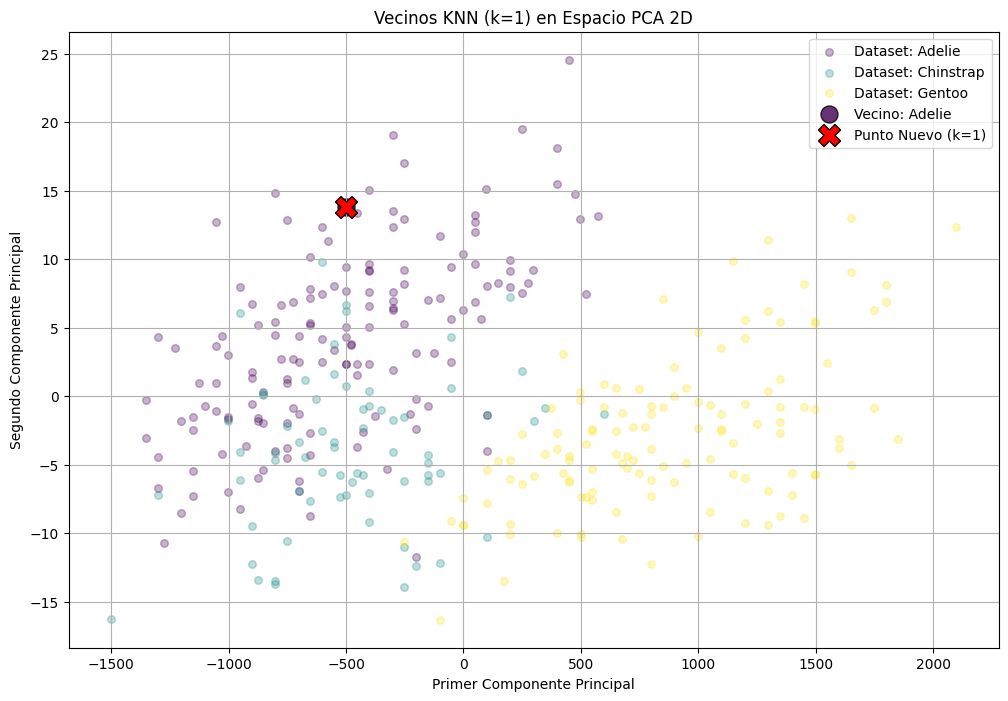

Graficando para k=3...


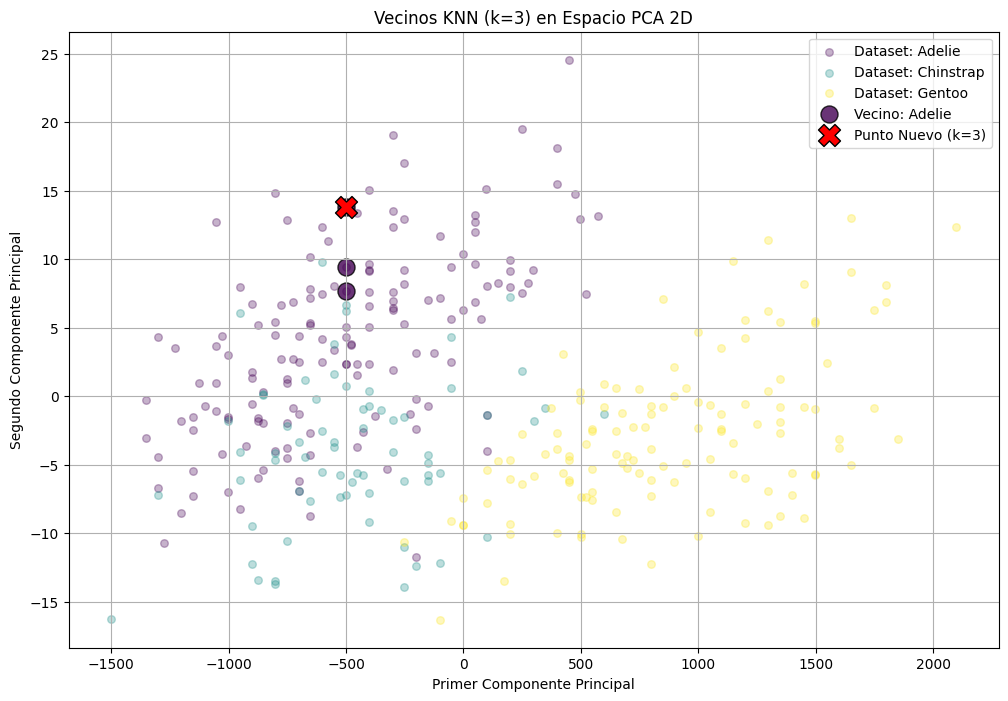

Graficando para k=5...


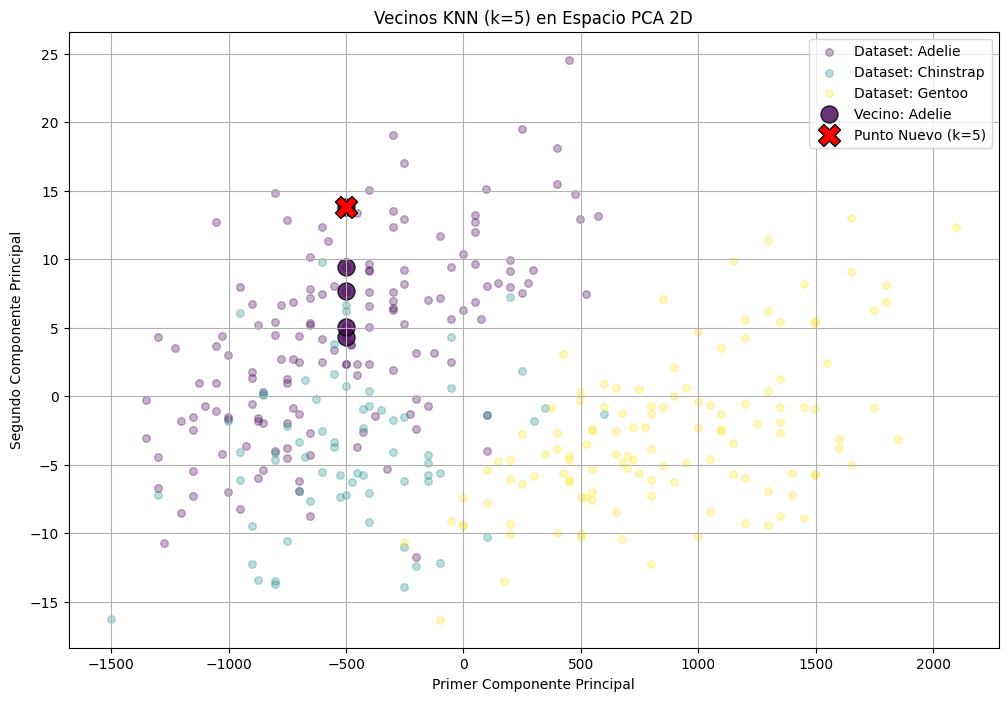

In [144]:
#Demostracion de la funcion plot_neighbors del clasificador KNN
print("\nDemostrando plot_neighbors")

#Verificar que haya al menos una muestra disponible
if X.shape[0] > 0:

    #Elige un indice para la muestra que se va a graficar
    idx_for_plot = min(10, X.shape[0] - 1)
    if idx_for_plot < 0:
        idx_for_plot = 0

    #Extraer las caracteristicas y la etiqueta real de la muestra seleccionada
    new_sample_features = X[idx_for_plot]
    actual_label_for_new_sample = y[idx_for_plot]

    print(f"Graficando vecinos para la muestra con características: {new_sample_features}")
    print(f"Etiqueta real de esta muestra: {actual_label_for_new_sample}")

    #Verificar que haya suficientes ejemplares y caracteristicas para aplicar PCA y graficar
    if len(knn_classifier._exemplars) > 2 and X.shape[1] >= 2:

        #Iterar sobre distintos valores de k para graficar los vecinos
        for k_plot in [1, 3, 5]:
            # Solo grafica si k no supera el número de ejemplares disponibles
            if k_plot <= len(knn_classifier._exemplars):
                print(f"Graficando para k={k_plot}...")
                knn_classifier.plot_neighbors(
                    new_sample_features,
                    k=k_plot,
                    X_all_features_for_pca=X,
                    y_all_labels_for_pca=y
                )
            else:
                print(
                    f"Omitiendo gráfico para k={k_plot} ya que es mayor que las muestras de entrenamiento ({len(knn_classifier._exemplars)})")
    else:
        print("Omitiendo plot_neighbors: No hay suficientes muestras de entrenamiento o características para un PCA significativo.")
else:
    print("Omitiendo plot_neighbors: No hay datos disponibles.")